In [ ]:
import os

# Set the CUBLAS_WORKSPACE_CONFIG environment variable
# The error message suggests :4096:8 or :16:8. The first is generally preferred.
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

## Display function

In [ ]:
#function for displaying ROC curves of multiple classifiers

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import auc

def plot_roc_connected_points(results_list, results_original_roc, name="All Classifiers"):
    """
    Creates a plot showing the performance of all classifiers as points,
    and connects them with a line, sorted by FPR.

    Args:
        results_list: A list of dictionaries, where each dict contains 'fpr', 'tpr'.
    """
    if not results_list:
        print("No results to plot.")
        return

    # Convert results to a pandas DataFrame for easy sorting
    df = pd.DataFrame(results_list)
    
    # Sort the models by their False Positive Rate to create a left-to-right line
    df_sorted = df.sort_values(by='fpr').reset_index(drop=True)
    
    # --- Plotting ---
    plt.figure(figsize=(10, 10))
    
    # Plot all the individual model points as a scatter plot
    # This helps see the actual performance of each model
    plt.scatter(df_sorted['fpr'], df_sorted['tpr'], c='black', marker='o', 
                alpha=0.6, s=100, zorder=3) # zorder=3 puts dots on top

    # Plot the line connecting the points
    plt.plot(df_sorted['fpr'], df_sorted['tpr'], color='red', lw=1.5,
             alpha=0.8, label=f'{name} (AUC = {auc(df_sorted["fpr"], df_sorted["tpr"]):.2f})')
    
    #plot the original ROC curve
    plt.plot(results_original_roc["fpr"], results_original_roc["tpr"], color='blue', 
             label=f'{results_original_roc["name"]} (AUC = {results_original_roc["auc"]:.2f})')

    # Plot the "no-skill" line for reference
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Performance Path of All Trained Classifiers')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

## Best ROC envelope

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve

def get_best_roc_envelope(results_list, results_original_roc=None):
    """
    Constructs the upper envelope of multiple ROC curves to find the best
    possible operating points from a collection of classifiers.

    This function is guaranteed to produce a list of points that starts at
    (FPR=0, TPR=0) and ends at (FPR=1, TPR=1), making it suitable for direct
    plotting and AUC calculation.

    Args:
        results_list (list): A list of dictionaries. Each dictionary must
                             contain a 'model' name and the full ROC results
                             under the 'full_roc' key.
        results_original_roc (dict, optional): A dictionary containing the
                                               ROC results of a baseline model,
                                               which will also be included in
                                               the comparison. Defaults to None.

    Returns:
        list: A sorted list of dictionaries representing the optimal ROC
              envelope. Each dictionary includes 'model', 'fpr', 'tpr',
              and 'threshold'.
    """
    all_points = []

    # Step 1: Gather all ROC points from all provided models
    all_results = results_list[:]
    if results_original_roc:
        all_results.append({
            'model': 'original_baseline',
            'full_roc': results_original_roc
        })

    for result in all_results:
        model_name = result.get('model', 'Unknown Model')
        roc = result.get('full_roc')
        if not roc: continue

        fprs = roc.get('fpr', [])
        tprs = roc.get('tpr', [])
        thresholds = roc.get('thresholds', [])

        for i in range(len(fprs)):
            threshold = thresholds[i] if i < len(thresholds) else thresholds[-1]
            all_points.append({
                'model': model_name, 'fpr': fprs[i],
                'tpr': tprs[i], 'threshold': threshold
            })

    # Handle case with no data by returning a default diagonal line
    if not all_points:
        return [
            {'model': 'start', 'fpr': 0.0, 'tpr': 0.0, 'threshold': np.inf},
            {'model': 'end', 'fpr': 1.0, 'tpr': 1.0, 'threshold': 0.0}
        ]

    # Step 2: Sort all points by FPR (asc), then by TPR (desc)
    all_points.sort(key=lambda p: (p['fpr'], -p['tpr']))

    # Step 3: Build the core ROC envelope
    best_roc_envelope = []
    max_tpr_so_far = -1.0
    for point in all_points:
        # Add a point only if it has a strictly higher TPR
        if point['tpr'] > max_tpr_so_far:
            # To prevent adding multiple points at the same FPR, check if the last point
            # has the same FPR and replace it if so (since this one has a higher TPR)
            if best_roc_envelope and best_roc_envelope[-1]['fpr'] == point['fpr']:
                best_roc_envelope[-1] = point
            else:
                best_roc_envelope.append(point)
            max_tpr_so_far = point['tpr']
    
    # Step 4: Manually add extremities if they are missing
    
    # Ensure the curve starts at (0, 0)
    if not best_roc_envelope or best_roc_envelope[0]['fpr'] > 0.0:
        best_roc_envelope.insert(0, {
            'model': 'start', 'fpr': 0.0, 'tpr': 0.0, 'threshold': np.inf
        })

    # Ensure the curve ends at (1, 1)
    if best_roc_envelope[-1]['fpr'] < 1.0 or best_roc_envelope[-1]['tpr'] < 1.0:
        best_roc_envelope.append({
            'model': 'end', 'fpr': 1.0, 'tpr': 1.0, 'threshold': 0.0
        })

    return best_roc_envelope

## Function for filtering the result_list

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve
def filter_roc_results(results_list, results_original_roc, depth=1):
    """
    Filters the ROC results to include only those that are better than the original ROC curve.
    Each results_list item will compare its TPR against the original ROC curve's TPR at the same FPR.
    This function assumes that the results_list contains dictionaries with 'fpr', 'tpr' keys.
    If the TPR of a model at a given FPR is greater than the original model's TPR,
    it is considered a better model and included in the filtered results.
    If the FPR of a model is not present in the original ROC curve, then extrapolate
    the TPR value from the original ROC curve using linear interpolation.
    If the TPR of a model for a given FPR is equal to or worse than the original model's TPR, then
    we compute ROC results of the previous model in the list and compare the TPR with the original_model TPR for that FPR.
    If the above step still does not yield a better model, then we perform the same operation for the next model in the list.
    If still we do not find a better model, then we pick the original model as the best model for that FPR.
    The depth parameter defines how many models to look back and forward in the list
    to find a substitute model that performs better than the original model at the same FPR. 

    Args:
        results_list: A list of dictionaries containing the ROC results of the models.
        results_original_roc: A dictionary containing the ROC results of the original model.

    Returns:
        A filtered list of dictionaries containing only the relevant ROC results.
    """
    final_roc_points = []
    original_fprs = np.array(results_original_roc['fpr'])
    original_tprs = np.array(results_original_roc['tpr'])
    original_thresholds = np.array(results_original_roc['thresholds'])

    for i, current_data in enumerate(results_list):
        current_fpr = current_data["fpr"]
        current_tpr = current_data["tpr"]
        current_threshold = current_data["threshold"]

        original_tpr_at_current_fpr = np.interp(current_fpr, original_fprs, original_tprs)

        # 1. Is the current model's point better than the baseline?
        if current_tpr > original_tpr_at_current_fpr:
            final_roc_points.append({
                "model": current_data["model"],
                "fpr": current_fpr,
                "tpr": current_tpr,
                "threshold": current_threshold
            })
            continue

        # 2. NO. Search for the best substitute within the defined depth.
        best_substitute = None
        # Start by assuming the baseline is the best we can do. We need to beat this.
        best_substitute_tpr = original_tpr_at_current_fpr

        # Define the search window
        start_index = max(0, i - depth)
        end_index = min(len(results_list), i + depth + 1)

        for j in range(start_index, end_index):
            # Don't compare the model with itself
            if i == j:
                continue

            candidate_data = results_list[j]
            candidate_roc = candidate_data["full_roc"]
            
            # Find the candidate's performance at the current FPR
            candidate_tpr = np.interp(current_fpr, candidate_roc["fpr"], candidate_roc["tpr"])

            # If this candidate is the best substitute found so far...
            if candidate_tpr > best_substitute_tpr:
                best_substitute_tpr = candidate_tpr
                
                # ...find its corresponding threshold and store its info.
                idx = np.searchsorted(candidate_roc["fpr"], current_fpr)
                chosen_threshold = candidate_roc["thresholds"][max(0, idx - 1)]
                best_substitute = {
                    "model": candidate_data["model"],
                    "tpr": candidate_tpr,
                    "threshold": chosen_threshold
                }
        
        # 3. After searching, did we find a worthy substitute?
        if best_substitute:
            # YES. A substitute from the window was better than the baseline.
            best_substitute["fpr"] = current_fpr # Add the FPR to the dict
            final_roc_points.append(best_substitute)
        else:
            # NO. No model in the window was better. Fall back to the baseline.
            idx = np.searchsorted(original_fprs, current_fpr)
            chosen_threshold = original_thresholds[max(0, idx - 1)]
            final_roc_points.append({
                "model": "original_baseline",
                "fpr": current_fpr,
                "tpr": original_tpr_at_current_fpr,
                "threshold": chosen_threshold
            })

    # Find the min and max FPR values in the final results
    # if min FPR is greater than 0, use the operation points from 0 to min FPR of the model with the min FPR to fill the gap
    # we do the same for the max FPR less than 1
     # If no points were selected, return an empty list
    if not final_roc_points:
        return []

    # --- Start of the completed section ---

    # Find the point with the minimum FPR to start the curve
    min_fpr_point = min(final_roc_points, key=lambda x: x['fpr'])
    min_fpr_val = min_fpr_point['fpr']
    min_fpr_model_name = min_fpr_point['model']

    initial_points = []
    if min_fpr_val > 0:
        # Get the full ROC of the model with the minimum FPR
        if min_fpr_model_name == 'original_baseline':
            min_model_roc = results_original_roc
        else:
            min_model_data = next((item for item in results_list if item['model'] == min_fpr_model_name), None)
            min_model_roc = min_model_data['full_roc'] if min_model_data else None

        if min_model_roc:
            roc_fprs = np.array(min_model_roc['fpr'])
            roc_tprs = np.array(min_model_roc['tpr'])
            roc_thresholds = np.array(min_model_roc['thresholds'])
            
            indices_to_add = np.where(roc_fprs < min_fpr_val)[0]
            for idx in indices_to_add:
                initial_points.append({
                    "model": min_fpr_model_name,
                    "fpr": roc_fprs[idx],
                    "tpr": roc_tprs[idx],
                    "threshold": roc_thresholds[idx]
                })

    # Find the point with the maximum FPR to end the curve
    max_fpr_point = max(final_roc_points, key=lambda x: x['fpr'])
    max_fpr_val = max_fpr_point['fpr']
    max_fpr_model_name = max_fpr_point['model']
    
    trailing_points = []
    if max_fpr_val < 1.0:
        # Get the full ROC of the model with the maximum FPR
        if max_fpr_model_name == 'original_baseline':
            max_model_roc = results_original_roc
        else:
            max_model_data = next((item for item in results_list if item['model'] == max_fpr_model_name), None)
            max_model_roc = max_model_data['full_roc'] if max_model_data else None
        
        if max_model_roc:
            roc_fprs = np.array(max_model_roc['fpr'])
            roc_tprs = np.array(max_model_roc['tpr'])
            roc_thresholds = np.array(max_model_roc['thresholds'])

            indices_to_add = np.where(roc_fprs > max_fpr_val)[0]
            for idx in indices_to_add:
                trailing_points.append({
                    "model": max_fpr_model_name,
                    "fpr": roc_fprs[idx],
                    "tpr": roc_tprs[idx],
                    "threshold": roc_thresholds[idx]
                })

    # Combine all points
    combined_points = initial_points + final_roc_points + trailing_points

    # Sort by FPR (and then by descending TPR to keep the best point) and remove duplicates
    combined_points.sort(key=lambda p: (p['fpr'], -p['tpr']))
    
    unique_roc_points = []
    seen_fprs = set()
    for point in combined_points:
        if point['fpr'] not in seen_fprs:
            unique_roc_points.append(point)
            seen_fprs.add(point['fpr'])

    return unique_roc_points

## Data generation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def generate_data(dataset):
    if dataset == "data1":
        no_predictors = 2
        no_samples = 1000
        no_classes = 2
        #kerneltype = 'linear'  #comment out for polynomial kernel
        #kerneltype = 'poly'  #comment out for linear kernel



        n_samples_per_cluster = 250
        n_clusters = 4

        # Create the clusters deterministically
        np.random.seed(0) # for reproducibility

        X = np.zeros((n_samples_per_cluster * n_clusters, 2))
        y = np.zeros(n_samples_per_cluster * n_clusters)

        # Cluster centers in corners of a square
        centers = [[0, 0], [2, 0], [0, 2], [2, 2]]

        # Assign points to clusters deterministically
        for i in range(n_clusters):
            cluster_indices = slice(i * n_samples_per_cluster, (i + 1) * n_samples_per_cluster)
            X[cluster_indices] = centers[i] + np.random.normal(scale=0.5, size=(n_samples_per_cluster, 2))
            if i == 0 or i == 3:
                y[cluster_indices] = 0
            else:
                y[cluster_indices] = 1



        #Visualize
        plt.figure(figsize=(8,8))
        plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=50)
        plt.title('Four Clusters of Equal Size')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.show()

        #add intercept to X
        #X = np.hstack((np.ones((X.shape[0], 1)), X))

        # # shuffle data
        # permutation = np.random.permutation(no_samples)
        # X = X[permutation]
        # y = y[permutation]


        #Split data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        train_data = np.concatenate((X_train, y_train.reshape(-1, 1)), axis=1)
        test_data = np.concatenate((X_test, y_test.reshape(-1, 1)), axis=1)
        val_data = test_data
        
        print(f"Training data shape: {X_train.shape}, {y_train.shape}")
        print(f"Test data shape: {X_test.shape}, {y_test.shape}")
    elif dataset == "data2":
        no_predictors = 2
        no_samples = 1000
        no_classes = 2
        #kerneltype = 'linear'  #comment out for polynomial kernel
        #kerneltype = 'poly'  #comment out for linear kernel



        n_samples_per_cluster = 250
        n_clusters = 4

        # Create the clusters deterministically
        np.random.seed(0) # for reproducibility

        X = np.zeros((n_samples_per_cluster * n_clusters, 2))
        y = np.zeros(n_samples_per_cluster * n_clusters)

        # Cluster centers in corners of a square
        centers = [[0, 0], [2, 0], [1, 2], [1, 2]]

        # Assign points to clusters deterministically
        for i in range(n_clusters):
            cluster_indices = slice(i * n_samples_per_cluster, (i + 1) * n_samples_per_cluster)
            X[cluster_indices] = centers[i] + np.random.normal(scale=0.5, size=(n_samples_per_cluster, 2))
            if i == 0 or i == 3:
                y[cluster_indices] = 0
            else:
                y[cluster_indices] = 1



        #Visualize
        plt.figure(figsize=(8,8))
        plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=50)
        plt.title('Four Clusters of Equal Size')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.show()

        #add intercept to X
        #X = np.hstack((np.ones((X.shape[0], 1)), X))

        # # shuffle data
        # permutation = np.random.permutation(no_samples)
        # X = X[permutation]
        # y = y[permutation]


        #Split data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        train_data = np.concatenate((X_train, y_train.reshape(-1, 1)), axis=1)
        test_data = np.concatenate((X_test, y_test.reshape(-1, 1)), axis=1)
        val_data = test_data
        
        print(f"Training data shape: {X_train.shape}, {y_train.shape}")
        print(f"Test data shape: {X_test.shape}, {y_test.shape}")

    elif dataset == "pneumoniaMNIST":
        import medmnist
        print(medmnist.__version__)
        # read in the PneumoniaMNIST dataset
        from medmnist import PneumoniaMNIST
        train_data = PneumoniaMNIST(split='train', download=True, size=224)
        test_data = PneumoniaMNIST(split='test', download=True, size=224)
        val_data = PneumoniaMNIST(split='val', download=True, size=224)
        # print the dataset info
        print(f"Number of training samples: {len(train_data)}")
        print(f"Number of test samples: {len(test_data)}")
        print(f"Number of validation samples: {len(val_data)}")

    return train_data, test_data, val_data


## Calculate Statistics function

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix

def get_fpr_tpr(clf_model, X_test, y_test, threshold=0.5):
    """
    Calculates the False Positive Rate (FPR) and True Positive Rate (TPR) at a given threshold.

    Args:
        X_test: The test features.
        y_test: The true test labels (0 or 1).
        threshold: The probability threshold.

    Returns:
        A dictionary containing the FPR and TPR. Returns None if there's an error.
    """
    try:
        y_prob = clf_model.predict_proba(X_test)[:, 1]
        y_pred = (y_prob >= threshold).astype(int)

        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  #Avoid division by zero
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0 #Avoid division by zero
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        misclassification_rate = 1 - accuracy

        return {"fpr": fpr, "tpr": tpr, "precision": precision, "recall": recall, "f1": f1, "accuracy": accuracy, "misclassification_rate": misclassification_rate}

    except ValueError as e:
        print(f"Error calculating FPR and TPR: {e}")
        return None





## PneumoniaMNIST: NN

In [ ]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

In [ ]:
# Define constants
BATCH_SIZE = 64
LEARNING_RATE = 0.001
IMAGE_SIZE = 224
NUM_CLASSES = 1
NUM_CHANNELS = 1
NUM_EPOCHS = 1
NUM_WORKERS = 4

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, in_channels, num_classes, image_height, image_width):
        super(SimpleCNN, self).__init__()
        #Convoluional layers
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 224x224 -> 112x112
        
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 112x112 -> 56x56
        
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 56x56 -> 28x28
        
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # 28x28 -> 14x14
        )

        # --- DYNAMIC FLATTENED SIZE CALCULATION ---
        # Create a dummy tensor with the specified input dimensions
        dummy_input = torch.randn(1, in_channels, image_height, image_width)
        # Pass it through the feature extractor to see the output shape
        dummy_output = self.features(dummy_input)
        # The number of elements in the output tensor is our flattened size
        self.flattened_size = dummy_output.numel()

        # Fully connected layers
        self.fc1 = nn.Linear(self.flattened_size, 512)
        self.relu_fc = nn.ReLU()
        # Output layer: num_classes=1 for binary classification (outputting logits)
        self.fc2 = nn.Linear(512, num_classes)

    def extract_features(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1) # Flatten the tensor
        x = self.fc1(x)
        x = self.relu_fc(x)
        return x

    def forward(self, x):
        x = self.extract_features(x)
        x = self.fc2(x)
        return x

### Lightning module

In [ ]:
import torchmetrics
import pytorch_lightning as pl

class LitSimpleCNN(pl.LightningModule):
    def __init__(self, in_channels, num_classes, learning_rate, image_height, image_width, training_mode='full_network'):
        super().__init__()
        # Save hyperparameters
        self.save_hyperparameters()
        
        # Define the model
        self.model = SimpleCNN(
            in_channels=self.hparams.in_channels, 
            num_classes=self.hparams.num_classes,
            image_height=self.hparams.image_height,
            image_width=self.hparams.image_width
        )
        
        # Define loss function
        self.criterion = nn.BCEWithLogitsLoss()

        # Define metrics
        self.train_accuracy = torchmetrics.Accuracy(task="binary")
        self.val_accuracy = torchmetrics.Accuracy(task="binary")
        self.val_auc = torchmetrics.AUROC(task="binary")

        self.test_accuracy = torchmetrics.Accuracy(task="binary")
        self.test_auc = torchmetrics.AUROC(task="binary")
        self.test_precision = torchmetrics.Precision(task="binary")
        self.test_recall = torchmetrics.Recall(task="binary")
        self.test_f1 = torchmetrics.F1Score(task="binary")

        # This list will store outputs from each test step
        self.last_test_results = {}
        self.test_step_outputs = []


    def forward(self, x):
        return self.model(x)
    
    def freeze_feature_extractor(self):
        print("Freezing feature extractor layers...")
        for param in self.model.features.parameters():
            param.requires_grad = False
        for param in self.model.fc1.parameters():
            param.requires_grad = False

    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        # For BCEWithLogitsLoss, labels must be float
        labels = labels.float()
        
        outputs = self(inputs) # Forward pass
        loss = self.criterion(outputs, labels)

        # We need to handle which part of the network we are training
        if self.hparams.training_mode == 'full_network':
            self.log('train_loss_full', loss)
        elif self.hparams.training_mode == 'classifier_only':
            self.log('train_loss_classifier', loss)
        
        # Log metrics
        self.train_accuracy(outputs, labels.int())
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        self.log('train_acc', self.train_accuracy, on_step=True, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, labels = batch
        labels = labels.float()
        
        outputs = self(inputs)
        loss = self.criterion(outputs, labels)
        
        # Log metrics
        self.val_accuracy(outputs, labels.int())
        self.val_auc(outputs, labels.int())
        self.log('val_loss', loss, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        self.log('val_acc', self.val_accuracy, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        self.log('val_auc', self.val_auc, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)

    def test_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self.model(inputs)
        loss = self.criterion(outputs, labels.float())
        
        # Append predictions and labels to our list
        self.test_step_outputs.append({"preds": outputs.detach(), "labels": labels.detach()})
        
        # Log the loss for this batch
        self.log('test_loss', loss)
        return {"loss": loss}

    def on_test_epoch_end(self):
        # Concatenate all predictions and labels from the list we built
        all_preds = torch.cat([x['preds'] for x in self.test_step_outputs])
        all_labels = torch.cat([x['labels'] for x in self.test_step_outputs])

        # Calculate final metrics over the entire test set
        test_acc = self.test_accuracy(all_preds, all_labels.int())
        test_auc_val = self.test_auc(all_preds, all_labels.int())
        test_prec = self.test_precision(all_preds, all_labels.int())
        test_rec = self.test_recall(all_preds, all_labels.int())
        test_f1_val = self.test_f1(all_preds, all_labels.int())
        test_cm_val = torchmetrics.functional.confusion_matrix(all_preds, all_labels.int(), task="binary")

        # Log the final metrics
        self.log("test_acc_epoch", test_acc)
        self.log("test_auc_epoch", test_auc_val)

        print(f"\n--- Final Test Metrics ---")
        print(f"Accuracy: {test_acc:.4f}")
        print(f"AUC: {test_auc_val:.4f}")
        print(f"Precision: {test_prec:.4f}")
        print(f"Recall: {test_rec:.4f}")
        print(f"F1-Score: {test_f1_val:.4f}")
        print(f"Confusion Matrix:\n{test_cm_val}")
        print("--------------------------\n")

        # Calculate data for the ROC Curve
        fpr, tpr, thresholds = torchmetrics.functional.roc(
            torch.sigmoid(all_preds),
            all_labels.int(),
            task="binary"
        )

        # Store the results to be retrieved later in the main script
        self.last_test_results = {
            "fpr": fpr.cpu(),
            "tpr": tpr.cpu(),
            "auc": test_auc_val,
            "f1": test_f1_val,
            "precision": test_prec,
            "recall": test_rec,
            "cm": test_cm_val,
            "thresholds": thresholds.cpu(),
        }
        # Free up memory
        self.test_step_outputs.clear()

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
        return optimizer
    
    def extract_features_from_dataloader(self, dataloader):
        """
        Extracts features and corresponding labels from a given dataloader.

        Args:
            dataloader (torch.utils.data.DataLoader): The dataloader to process.

        Returns:
            tuple: A tuple containing:
                - torch.Tensor: A tensor of all extracted features.
                - torch.Tensor: A tensor of all corresponding labels.
        """
        # Set the model to evaluation mode to disable dropout, batch norm updates, etc.
        self.model.eval()
        
        all_features = []
        all_labels = []

        # Disable gradient calculations for efficiency
        with torch.no_grad():
            for inputs, labels in dataloader:
                # Move inputs to the same device as the model
                inputs = inputs.to(self.device)
                
                # Use the feature extraction method from the underlying SimpleCNN
                features = self.model.extract_features(inputs)
                
                # Append the results to our lists. Move to CPU to avoid filling up GPU memory.
                all_features.append(features.cpu())
                all_labels.append(labels.cpu())

        # Concatenate all the collected batches into single tensors
        final_features = torch.cat(all_features, dim=0)
        final_labels = torch.cat(all_labels, dim=0)

        # It's good practice to set the model back to train mode if you plan to continue training
        self.model.train()
        
        return final_features, final_labels

### Classifier only

In [90]:
import torch
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl
import torchmetrics
import numpy as np

# A simple classifier head
class SimpleClassifier(nn.Module):
    def __init__(self, input_features=512, num_classes=1):
        super().__init__()
        self.output_layer = nn.Linear(input_features, num_classes)

    def forward(self, x):
        return self.output_layer(x)

# A new LightningModule just for training the classifier
class LitClassifier(pl.LightningModule):
    def __init__(self, input_features=512, num_classes=1, learning_rate=1e-4):
        super().__init__()
        self.save_hyperparameters()
        self.model = SimpleClassifier(input_features, num_classes)
        self.criterion = nn.BCEWithLogitsLoss()
        
        # --- METRICS ---
        self.train_accuracy = torchmetrics.Accuracy(task="binary")
        self.test_accuracy = torchmetrics.Accuracy(task="binary")
        self.test_auc = torchmetrics.AUROC(task="binary")
        
        # This list will store outputs from each test step
        self.test_step_outputs = []
        # This dictionary will hold the final results
        self.last_test_results = {}

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        features, labels = batch
        outputs = self(features)
        
        # For the loss function, labels need to be reshaped to match outputs
        loss = self.criterion(outputs, labels.float().view(-1, 1))
        
        # For metrics, squeeze predictions to match labels' shape
        self.train_accuracy(outputs.squeeze(), labels.int())
        
        self.log('classifier_train_loss', loss, on_step=False, on_epoch=True)
        self.log('classifier_train_acc', self.train_accuracy, on_step=False, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        features, labels = batch
        outputs = self.model(features)
        loss = self.criterion(outputs, labels.float().view(-1, 1))

        # Append predictions and labels to our list for aggregation
        self.test_step_outputs.append({"preds": outputs.detach(), "labels": labels.detach()})
        
        self.log('test_loss', loss)
        return {"loss": loss}

    def on_test_epoch_end(self):
        if not self.test_step_outputs:
            return # Avoid errors if test loop was empty

        # Concatenate all predictions and labels
        all_preds = torch.cat([x['preds'] for x in self.test_step_outputs])
        all_labels = torch.cat([x['labels'] for x in self.test_step_outputs])

        # --- FIX: Squeeze BOTH predictions and labels to ensure they match ---
        squeezed_preds = all_preds.squeeze()
        all_probs = torch.sigmoid(squeezed_preds)
        # The labels tensor might also be [N, 1], so we squeeze it as well.
        int_labels = all_labels.squeeze().int()

        # Calculate final scalar metrics
        test_acc = self.test_accuracy(squeezed_preds, int_labels)
        test_auc_val = self.test_auc(squeezed_preds, int_labels)


        # Get the confusion matrix stats at the default 0.0 logit threshold
        tp, fp, tn, fn, _ = torchmetrics.functional.stat_scores(
            all_probs, int_labels, task="binary", threshold=0.5
        ) 
        
        # Calculate TPR and FPR from these raw scores
        epsilon = 1e-6
        tpr_at_0 = tp / (tp + fn + epsilon)
        fpr_at_0 = fp / (fp + tn + epsilon)

        # Calculate data for the full ROC Curve
        fpr_full, tpr_full, thresholds_full = torchmetrics.functional.roc(
            torch.sigmoid(squeezed_preds),
            int_labels,
            task="binary"
        )




        print(f"\n--- Final Classifier Test Metrics ---")
        print(f"Accuracy: {test_acc:.4f}")
        print(f"AUC: {test_auc_val:.4f}")
        print("-------------------------------------\n")
        
        self.last_test_results = {
            "w": self.hparams.get('w'),
            "fpr": fpr_at_0.cpu().numpy(),
            "tpr": tpr_at_0.cpu().numpy(),
            "threshold": 0.5,
            "auc": test_auc_val.cpu().numpy(),
            "accuracy": test_acc.cpu().numpy(),
            "full_roc": {
                "fpr": fpr_full.cpu().numpy(),
                "tpr": tpr_full.cpu().numpy(),
                "thresholds": thresholds_full.cpu().numpy()
            }
        }
        self.test_step_outputs.clear()
        
    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.hparams.learning_rate)


### Generate data

In [ ]:
train_dataset, test_dataset, val_dataset = generate_data("pneumoniaMNIST")

# Ensure you have your train_loader and val_loader defined here
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_dataset.transform = data_transforms
test_dataset.transform = data_transforms
val_dataset.transform = data_transforms


train_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
#new_train_loader = data.DataLoader(new_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS) to be done inside the sample_ratio loop
test_loader = data.DataLoader(test_dataset, batch_size=int(BATCH_SIZE/4), shuffle=False, num_workers=NUM_WORKERS)
val_loader = data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [ ]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar
import numpy as np

# --- Place any constants or unchanging objects outside the loop ---
pl.seed_everything(42, workers=True)
progress_bar = TQDMProgressBar(refresh_rate=10)
best_model_paths = [] # List to store the path of the best model from each stage

# 1. Instantiate the LightningModule
model = LitSimpleCNN(
    in_channels=NUM_CHANNELS,
    num_classes=NUM_CLASSES,
    learning_rate=LEARNING_RATE,
    training_mode='full_network',  # Change to 'classifier_only' if you want to train only the classifier
    image_height=IMAGE_SIZE,
    image_width=IMAGE_SIZE
)

# Optional: Print model summary
# You need to move the model to a device first for torchsummary to work
# summary(model.to('cuda'), (NUM_CHANNELS, IMAGE_SIZE, IMAGE_SIZE))
# model.to('cpu') # Move it back if needed

checkpoint_callback_full_model = ModelCheckpoint(
    monitor='val_acc',
    dirpath='checkpoints/',
    filename='simple-cnn-full-{epoch:02d}-{val_acc:.2f}',
    save_top_k=1,
    mode='max',
)

train_trainer_1 = pl.Trainer(
    accelerator='gpu',                 # Use GPUs
    devices=1,                         # Number of GPUs to use
    #strategy='ddp_notebook',                    # DistributedDataParallel strategy (best for multi-GPU)
    max_epochs=NUM_EPOCHS,              # Total number of epochs
    callbacks=[checkpoint_callback_full_model, progress_bar],
    logger=pl.loggers.TensorBoardLogger("lightning_logs/", name="simple_cnn-full")
)

test_trainer_1 = pl.Trainer(
    accelerator='gpu',
    devices=1,  # Use only one GPU
    logger = pl.loggers.TensorBoardLogger("lightning_logs/", name="simple_cnn_test"),
    # Add the callback here so the Trainer can find the 'best' path
    callbacks=[checkpoint_callback_full_model],
    precision='16-mixed'  # Use mixed precision for testing
)


# --- Phase 1 Training ---
print(f"--- Starting Training for {NUM_EPOCHS} epochs on train_loader ---")
train_trainer_1.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

# CRITICAL: Save the path to the best model from this phase
path_after_phase1 = checkpoint_callback_full_model.best_model_path
print(f"Best model from Phase 1 saved to: {path_after_phase1}")

# --- Test 1: Evaluate the model from after Phase 1 ---
print(f"\n--- Testing model from Phase 1 checkpoint: {path_after_phase1} ---")
model.current_test_title = "ROC Curve after training on DataLoader 1"
model = LitSimpleCNN.load_from_checkpoint(path_after_phase1)  # Load the model from Phase 1
model.eval().to('cuda:0')  # Ensure the model is in evaluation mode and on GPU
test_trainer_1.test(model, dataloaders=test_loader, ckpt_path=path_after_phase1)
results_phase1 = model.last_test_results.copy()
results_original_roc = {"fpr": results_phase1["fpr"], "tpr": results_phase1["tpr"], "thresholds": results_phase1["thresholds"], "name": "Original NN PneumoniaMNIST", "auc": results_phase1["auc"], "model": model}

#------ Extract features from the training set for Phase 1 ------
training_features, training_labels = model.extract_features_from_dataloader(train_loader)
print(f"Extracted features shape: {training_features.shape}")
print(f"Extracted labels shape: {training_labels.shape}")

#------Extract features from the testing set for Phase 1 ------
testing_features, testing_labels = model.extract_features_from_dataloader(test_loader)
print(f"Extracted testing features shape: {testing_features.shape}")
print(f"Extracted testing labels shape: {testing_labels.shape}")

### Oversample

In [84]:
import numpy as np
from collections import Counter
# from imblearn.over_sampling import SMOTE # SMOTE is no longer used
# from sklearn.cluster import KMeans # K-Means is no longer used

# --- Configuration ---
EPSILON = 1e-9
# EXPECTED_MODES_PER_CLASS, etc. removed
# FIXED_TARGET_STD_SYNTHETIC removed

# --- Parameter for KDE-like generator ---
SIGMA_KDE_PERTURBATION = 0.1 # Adjust as needed



# --- Initial Data Analysis ---
counter = Counter(train_dataset.labels.squeeze().tolist())
Class0_initial = counter.get(0, 0)
Class1_initial = counter.get(1, 0)


class_ratio_low = 0.1   
class_ratio_high = 10.0 
num_points_below = 10 
num_points_above = 10 

if Class1_initial == 0 and Class0_initial == 0:
    print("ERROR: Both classes have zero samples initially. Cannot proceed.")
    alpha_target_actual_values = [] 
    current_class_ratio = 1.0
elif Class1_initial == 0:
    current_class_ratio = np.inf 
else:
    current_class_ratio = Class0_initial / Class1_initial

# ... (alpha_target_actual_values generation - same robust version) ...
alpha_target_list = []
if Class0_initial > 0 or Class1_initial > 0: 
    if current_class_ratio > 0 and not np.isinf(current_class_ratio): 
        alpha_target_list.append(current_class_ratio)
    _safe_class_ratio_low = max(class_ratio_low, EPSILON)
    if current_class_ratio > _safe_class_ratio_low and not np.isinf(current_class_ratio): 
        try:
            alpha_b = np.geomspace(_safe_class_ratio_low, current_class_ratio, num_points_below, endpoint=False)
            alpha_target_list.extend(alpha_b)
        except ValueError: pass
    if current_class_ratio < class_ratio_high and current_class_ratio >= 0 and not np.isinf(current_class_ratio): 
        try:
            _start_geom_above = max(current_class_ratio, _safe_class_ratio_low) 
            if class_ratio_high > _start_geom_above:
                 alpha_a = np.geomspace(_start_geom_above, class_ratio_high, num_points_above, endpoint=True)
                 if not np.isclose(_start_geom_above, current_class_ratio) and current_class_ratio >=_safe_class_ratio_low and current_class_ratio <= class_ratio_high :
                     alpha_target_list.append(current_class_ratio)
                 alpha_target_list.extend(alpha_a)
            elif np.isclose(class_ratio_high, _start_geom_above):
                 alpha_target_list.append(class_ratio_high)
        except ValueError: pass
    if not alpha_target_list and (Class0_initial > 0 or Class1_initial > 0): 
        if not np.isinf(current_class_ratio) and current_class_ratio > 0:
            alpha_target_list.append(current_class_ratio)
        else: 
            alpha_target_list.extend(np.geomspace(_safe_class_ratio_low, class_ratio_high, num_points_below + num_points_above))
    alpha_target_actual_values = np.unique(alpha_target_list)
    alpha_target_actual_values = np.sort(alpha_target_actual_values[alpha_target_actual_values >= 0]) 
    alpha_target_actual_values = alpha_target_actual_values[alpha_target_actual_values >= _safe_class_ratio_low] 
    alpha_target_actual_values = alpha_target_actual_values[alpha_target_actual_values <= class_ratio_high]
    if not alpha_target_actual_values.size and (Class0_initial > 0 or Class1_initial > 0) : 
        if not np.isinf(current_class_ratio) and current_class_ratio > _safe_class_ratio_low and current_class_ratio < class_ratio_high:
            alpha_target_actual_values = np.array([current_class_ratio])
        else: 
            alpha_target_actual_values = np.array([(_safe_class_ratio_low + class_ratio_high)/2.0])


# =======================================================================================
# --- FINAL FILTER: Remove w values that would result in generating zero samples ---
# =======================================================================================
print("\n--- Pre-filtering target ratios to find effective ones ---")
filtered_w_values = []
for w in alpha_target_actual_values:
    # Temporarily calculate the number of samples that WOULD be generated
    num_to_generate = 0
    
    if w < current_class_ratio:
        # Strategy is to increase Class 1
        if w > EPSILON:
            final_count = int(round(Class0_initial / w))
            num_to_generate = final_count - Class1_initial
    else: # This covers w >= current_class_ratio
        # Strategy is to increase Class 0
        final_count = int(round(Class1_initial * w))
        num_to_generate = final_count - Class0_initial
        
    # Only keep the w value if it results in at least one new sample
    if num_to_generate > 0:
        filtered_w_values.append(w)
    else:
        print(f"Filtering out w={w:.4f} as it would generate 0 samples.")

# Overwrite the old array with the new, clean, filtered list
alpha_target_actual_values = np.array(filtered_w_values)
# =======================================================================================


print(f"\nINFO: Initial C0={Class0_initial}, C1={Class1_initial}, Ratio(0/1): {current_class_ratio if Class1_initial > 0 else 'N/A'}")
print(f"INFO: Proceeding with {len(alpha_target_actual_values)} effective target ratios (w values): {alpha_target_actual_values}")
print(f"INFO: KDE-like perturbation sigma: {SIGMA_KDE_PERTURBATION}")
print(f"INFO: Standard deviation of synthetic samples will NOT be modified after generation.")


--- Pre-filtering target ratios to find effective ones ---
Filtering out w=0.3475 as it would generate 0 samples.

INFO: Initial C0=1214, C1=3494, Ratio(0/1): 0.34745277618775045
INFO: Proceeding with 19 effective target ratios (w values): [ 0.1         0.1132634   0.12828597  0.14530104  0.1645729   0.18640085
  0.21112393  0.23912614  0.27084238  0.30676528  0.50468277  0.73306278
  1.06478974  1.54663042  2.24651456  3.26311161  4.73974109  6.88457776
 10.        ]
INFO: KDE-like perturbation sigma: 0.1
INFO: Standard deviation of synthetic samples will NOT be modified after generation.


In [87]:
import torch
import numpy as np
from collections import Counter

def oversample_with_jittering(
    training_features,
    training_labels,
    alpha_target,
    sigma_perturbation,
    epsilon=1e-9
):
    """
    Oversamples a dataset by generating synthetic samples via noise injection (jittering)
    and combines them with the original data.

    This function is self-contained and does not rely on global variables.

    Args:
        training_features (torch.Tensor): Feature vectors of the original training set.
        training_labels (torch.Tensor): Labels of the original training set.
        alpha_target (float): The desired target ratio of (Class 0 / Class 1).
        sigma_perturbation (float): Std deviation of the Gaussian noise to add.
        epsilon (float): A small value to prevent division by zero.

    Returns:
        tuple: A tuple containing (X_resampled, y_resampled) as new torch tensors.
    """
    # --- 1. Initial Analysis (now done inside the function) ---
    counter = Counter(training_labels.squeeze().tolist())
    Class0_initial = counter.get(0, 0)
    Class1_initial = counter.get(1, 0)

    # This calculation must also be inside the function
    if Class1_initial == 0 and Class0_initial == 0:
        print("  WARN: Both classes are empty. Returning original (empty) dataset.")
        return training_features, training_labels
    elif Class1_initial == 0:
        current_class_ratio = np.inf
    else:
        current_class_ratio = Class0_initial / Class1_initial

    # --- 2. Determine Oversampling Strategy ---
    oversampled_class_label = -1
    num_to_generate = 0

    if alpha_target < current_class_ratio:
        # To decrease the ratio (C0/C1), we must INCREASE C1.
        oversampled_class_label = 1
        if alpha_target > epsilon:
            final_count = int(round(Class0_initial / alpha_target))
            num_to_generate = final_count - Class1_initial
    else: # This covers alpha_target >= current_class_ratio
        # To increase the ratio (C0/C1), we must INCREASE C0.
        oversampled_class_label = 0
        final_count = int(round(Class1_initial * alpha_target))
        num_to_generate = final_count - Class0_initial

    if num_to_generate <= 0:
        # This handles no-op cases cleanly
        print(f"  INFO: For w={alpha_target:.4f}, no new samples to generate. Returning original dataset.")
        return training_features, training_labels

    # --- 3. Generate Synthetic Samples ---
    print(f"  INFO: Strategy: Oversample class {oversampled_class_label} by generating {num_to_generate} new samples.")
    
    original_features_np = training_features.numpy()
    original_labels_np = training_labels.squeeze().numpy()
    
    indices_class = np.where(original_labels_np == oversampled_class_label)[0]

    if len(indices_class) == 0:
        print(f"  WARN: Cannot oversample class {oversampled_class_label} as it has no initial samples. Returning original dataset.")
        return training_features, training_labels

    seed_features = original_features_np[indices_class]
    
    # Generate new samples by adding noise
    new_features_list = [seed_features[_] + np.random.randn(*seed_features.shape[1:])*sigma_perturbation for _ in np.random.choice(len(seed_features), size=num_to_generate, replace=True)]
    new_features_np = np.array(new_features_list)
    new_labels_np = np.full(num_to_generate, oversampled_class_label)

    # --- 4. Combine and Return ---
    X_resampled = np.vstack([original_features_np, new_features_np])
    y_resampled = np.hstack([original_labels_np, new_labels_np])

    return torch.tensor(X_resampled, dtype=torch.float32), torch.tensor(y_resampled, dtype=torch.long)


In [91]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar
import numpy as np

# --- Place any constants or unchanging objects outside the loop ---
pl.seed_everything(42, workers=True)
progress_bar = TQDMProgressBar(refresh_rate=10)
list_weighted_clfs = [] # List to store the path of the best model from each stage

test_feature_dataset = data.TensorDataset(testing_features, testing_labels)
test_feature_loader = data.DataLoader(test_feature_dataset, batch_size=int(BATCH_SIZE), num_workers=NUM_WORKERS)

for w_idx, w in enumerate(alpha_target_actual_values):
    print(f"\n--- Processing target ratio w ({w_idx+1}/{len(alpha_target_actual_values)}): {w:.4f} ---")
    
    #oversample
    X_resampled, y_resampled = oversample_with_jittering(
        training_features,      # Pass features as an argument
        training_labels,        # Pass labels as an argument
        alpha_target=w,
        sigma_perturbation=SIGMA_KDE_PERTURBATION
    )

    

    # create the balanced_feature_dataset
    balanced_feature_dataset = data.TensorDataset(X_resampled, y_resampled)
    balanced_feature_loader = data.DataLoader(balanced_feature_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

    # A simpler approach is to fine-tune the original model
    print("\n--- Starting Second Stage Training (Classifier Only) ---")

    # Instantiate our new, simple classifier
    classifier_model = LitClassifier(learning_rate=LEARNING_RATE)

    trainer_classifier = pl.Trainer(
        accelerator='gpu',
        devices=1,
        max_epochs=1,
        deterministic=True
    )

    trainer_classifier.fit(classifier_model, train_dataloaders=balanced_feature_loader)

    # Test the classifier on the original test set
    print("\n--- Testing Classifier on Original Test Set ---")
    trainer_classifier.test(classifier_model, dataloaders=test_feature_loader)  
    results_classifier = classifier_model.last_test_results.copy()
    
    current_model = {
        "model": classifier_model,
        "fpr": results_classifier["fpr"],
        "tpr": results_classifier["tpr"],
        "threshold": results_classifier["threshold"],
        "full_roc": results_classifier["full_roc"]
    }
    list_weighted_clfs.append(current_model)


Seed set to 42



--- Processing target ratio w (1/19): 0.1000 ---
  INFO: Strategy: Oversample class 1 by generating 8646 new samples.


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 513    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
513       Trainable params
0         Non-trainable params
513       Total params
0.002     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



--- Starting Second Stage Training (Classifier Only) ---


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



--- Testing Classifier on Original Test Set ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.7949
AUC: 0.9257
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.647548258304596
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (2/19): 0.1133 ---
  INFO: Strategy: Oversample class 1 by generating 7224 new samples.


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 513    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
513       Trainable params
0         Non-trainable params
513       Total params
0.002     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



--- Starting Second Stage Training (Classifier Only) ---


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



--- Testing Classifier on Original Test Set ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8205
AUC: 0.9258
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6062512397766113
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (3/19): 0.1283 ---
  INFO: Strategy: Oversample class 1 by generating 5969 new samples.


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 513    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
513       Trainable params
0         Non-trainable params
513       Total params
0.002     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



--- Starting Second Stage Training (Classifier Only) ---


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



--- Testing Classifier on Original Test Set ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8221
AUC: 0.9261
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.587761402130127
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (4/19): 0.1453 ---
  INFO: Strategy: Oversample class 1 by generating 4861 new samples.


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 513    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
513       Trainable params
0         Non-trainable params
513       Total params
0.002     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



--- Starting Second Stage Training (Classifier Only) ---


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



--- Testing Classifier on Original Test Set ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8221
AUC: 0.9254
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.5750454068183899
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (5/19): 0.1646 ---
  INFO: Strategy: Oversample class 1 by generating 3883 new samples.

--- Starting Second Stage Training (Classifier Only) ---


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 513    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
513       Trainable params
0         Non-trainable params
513       Total params
0.002     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



--- Testing Classifier on Original Test Set ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Final Classifier Test Metrics ---
Accuracy: 0.8205
AUC: 0.9263
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6037267446517944
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (6/19): 0.1864 ---
  INFO: Strategy: Oversample class 1 by generating 3019 new samples.

--- Starting Second Stage Training (Classifier Only) ---


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 513    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
513       Trainable params
0         Non-trainable params
513       Total params
0.002     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



--- Testing Classifier on Original Test Set ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Final Classifier Test Metrics ---
Accuracy: 0.8205
AUC: 0.9255
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.560650110244751
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (7/19): 0.2111 ---
  INFO: Strategy: Oversample class 1 by generating 2256 new samples.

--- Starting Second Stage Training (Classifier Only) ---


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 513    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
513       Trainable params
0         Non-trainable params
513       Total params
0.002     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



--- Testing Classifier on Original Test Set ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8237
AUC: 0.9264
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.5179439187049866
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (8/19): 0.2391 ---
  INFO: Strategy: Oversample class 1 by generating 1583 new samples.

--- Starting Second Stage Training (Classifier Only) ---


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 513    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
513       Trainable params
0         Non-trainable params
513       Total params
0.002     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



--- Testing Classifier on Original Test Set ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.



--- Final Classifier Test Metrics ---
Accuracy: 0.8253
AUC: 0.9257
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.5144215822219849
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (9/19): 0.2708 ---
  INFO: Strategy: Oversample class 1 by generating 988 new samples.

--- Starting Second Stage Training (Classifier Only) ---


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 513    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
513       Trainable params
0         Non-trainable params
513       Total params
0.002     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



--- Testing Classifier on Original Test Set ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



--- Final Classifier Test Metrics ---
Accuracy: 0.8333
AUC: 0.9249
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.4596569240093231
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (10/19): 0.3068 ---
  INFO: Strategy: Oversample class 1 by generating 463 new samples.

--- Starting Second Stage Training (Classifier Only) ---



  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 513    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
513       Trainable params
0         Non-trainable params
513       Total params
0.002     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



--- Testing Classifier on Original Test Set ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Final Classifier Test Metrics ---
Accuracy: 0.8429
AUC: 0.9257
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.5041286945343018
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (11/19): 0.5047 ---
  INFO: Strategy: Oversample class 0 by generating 549 new samples.

--- Starting Second Stage Training (Classifier Only) ---


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 513    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
513       Trainable params
0         Non-trainable params
513       Total params
0.002     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



--- Testing Classifier on Original Test Set ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Final Classifier Test Metrics ---
Accuracy: 0.8446
AUC: 0.9249
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.4566284120082855
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (12/19): 0.7331 ---
  INFO: Strategy: Oversample class 0 by generating 1347 new samples.

--- Starting Second Stage Training (Classifier Only) ---


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 513    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
513       Trainable params
0         Non-trainable params
513       Total params
0.002     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



--- Testing Classifier on Original Test Set ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8494
AUC: 0.9255
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.4424533247947693
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (13/19): 1.0648 ---
  INFO: Strategy: Oversample class 0 by generating 2506 new samples.

--- Starting Second Stage Training (Classifier Only) ---


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 513    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
513       Trainable params
0         Non-trainable params
513       Total params
0.002     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



--- Testing Classifier on Original Test Set ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8638
AUC: 0.9247
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.4060169458389282
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (14/19): 1.5466 ---
  INFO: Strategy: Oversample class 0 by generating 4190 new samples.

--- Starting Second Stage Training (Classifier Only) ---


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 513    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
513       Trainable params
0         Non-trainable params
513       Total params
0.002     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



--- Testing Classifier on Original Test Set ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8718
AUC: 0.9247
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3772747218608856
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (15/19): 2.2465 ---
  INFO: Strategy: Oversample class 0 by generating 6635 new samples.


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 513    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
513       Trainable params
0         Non-trainable params
513       Total params
0.002     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



--- Starting Second Stage Training (Classifier Only) ---


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



--- Testing Classifier on Original Test Set ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8702
AUC: 0.9230
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3881470263004303
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (16/19): 3.2631 ---
  INFO: Strategy: Oversample class 0 by generating 10187 new samples.


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 513    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
513       Trainable params
0         Non-trainable params
513       Total params
0.002     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



--- Starting Second Stage Training (Classifier Only) ---


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



--- Testing Classifier on Original Test Set ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8702
AUC: 0.9251
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.37594732642173767
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (17/19): 4.7397 ---
  INFO: Strategy: Oversample class 0 by generating 15347 new samples.


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 513    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
513       Trainable params
0         Non-trainable params
513       Total params
0.002     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



--- Starting Second Stage Training (Classifier Only) ---


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



--- Testing Classifier on Original Test Set ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8670
AUC: 0.9238
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.37411171197891235
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (18/19): 6.8846 ---
  INFO: Strategy: Oversample class 0 by generating 22841 new samples.


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 513    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
513       Trainable params
0         Non-trainable params
513       Total params
0.002     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



--- Starting Second Stage Training (Classifier Only) ---


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



--- Testing Classifier on Original Test Set ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8510
AUC: 0.9246
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.39228910207748413
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (19/19): 10.0000 ---
  INFO: Strategy: Oversample class 0 by generating 33726 new samples.


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 513    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
513       Trainable params
0         Non-trainable params
513       Total params
0.002     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



--- Starting Second Stage Training (Classifier Only) ---


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



--- Testing Classifier on Original Test Set ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8221
AUC: 0.9223
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.44396737217903137
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


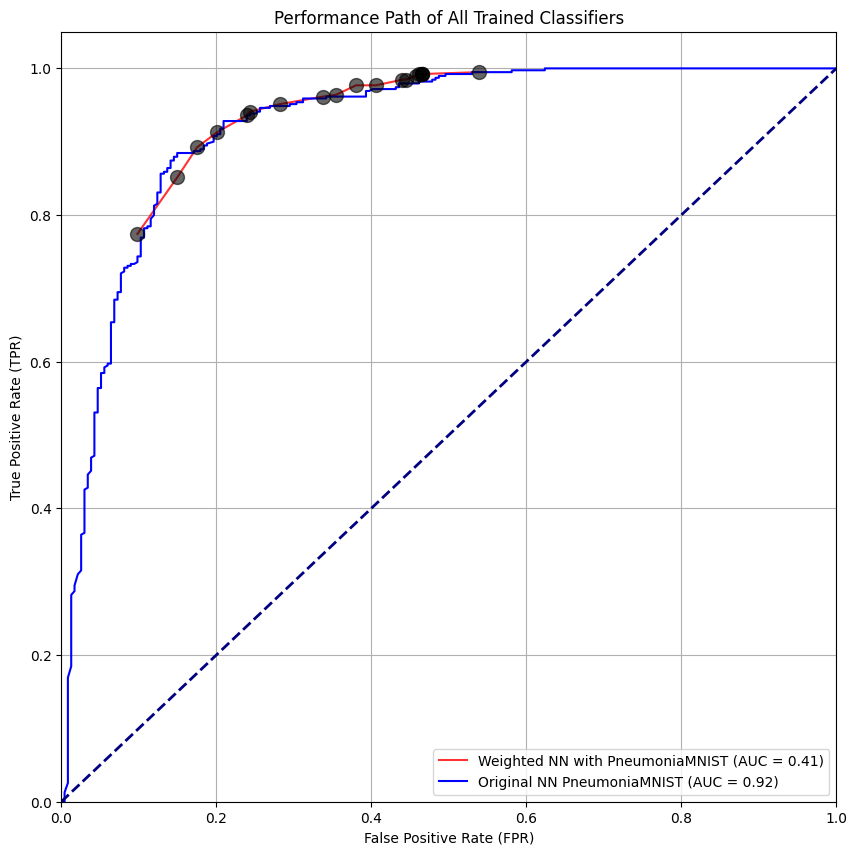

In [92]:
plot_roc_connected_points(list_weighted_clfs, results_original_roc, name="Weighted NN with PneumoniaMNIST")

/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:102: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/numpy/_core/_methods.py:53: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


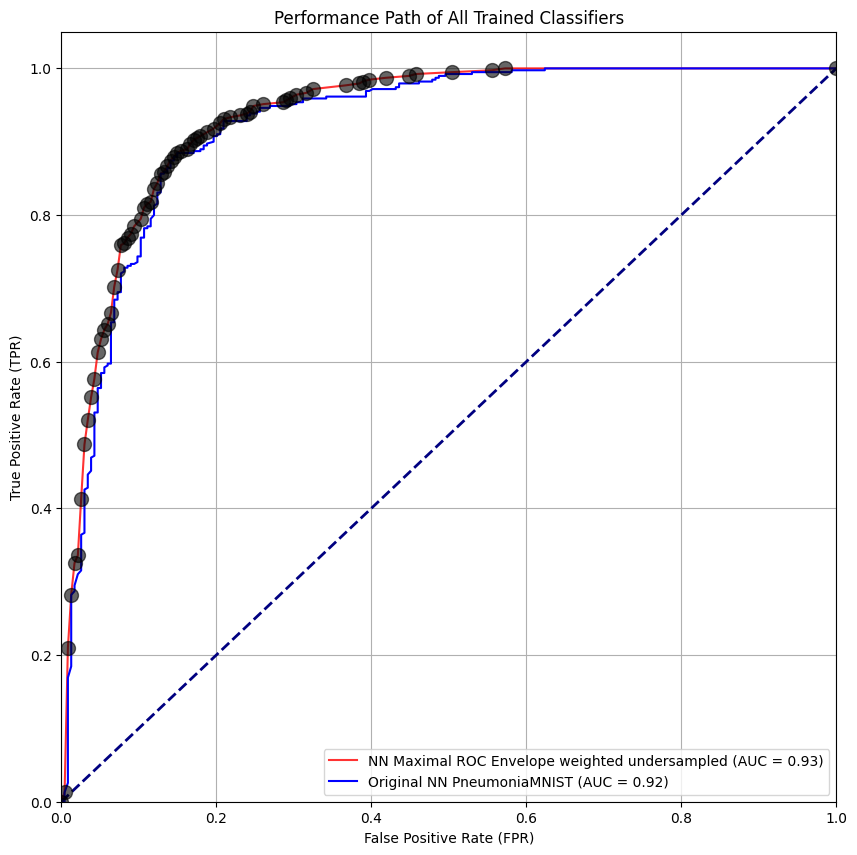

In [93]:
best_envelope = get_best_roc_envelope(list_weighted_clfs, results_original_roc)
# Plot the best ROC envelope
plot_roc_connected_points(best_envelope, results_original_roc, name="NN Maximal ROC Envelope weighted undersampled")